# Notebook to evaluate data quality with CNNs

#### TOPICOS PARA DISCUTIR
* Valores de intensidade das imagens
* Mostrar o codigo: Teste de Learning rate e modelos guardados do fitting do learning rate ideal (sem l2 regularization)
* Relação entre Loss e Accuracy (Valores elevados de accuracy para losses grandes?)
* Validação com split ou cross-validation

Conclusão: 
* R: A loss efetivamente está alta
* R: As curvas da validation loss estao estranhas
* R: Claro overfitting
* R: De modo geral os dados estão OK
* R: Sao poucas epochs

Notas:
* aumentar o batch faz com que as curvas de validacao (e treino) tenham maior estabilidade
* o minmax normalization é o método mais utilizado (para os meus dados parece fazer mais sentido: fazer um estudo na net breve para ver se descarto o z-score e faço so com o minmax. posso ate correr alguns testes para comparar)


### Alterar:
* Criar um set de validation (fazer primeiro o preprocessamento offline e depois comparar com o online antes de fazer cross-validation). Experimentar com cross-validation.
* adicionar titulos aos plots dos modelos (o coseno era o mais usado: prof)
* treinar com lr scheduler
* correr para muito tempo sem early stopping para ver se a loss fica mais pequena

Continuar noutro notebook quando for para fazer os testes a sério

In [2]:
# Load libraries
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from Resnet3D_model import Resnet3DBuilder
from sklearn.metrics import classification_report
from data_utils import create_dataset, clean_zone_identifier_files
from plotting_utils import view_image, view_random_image, plot_loss_curves, make_confusion_matrix

2025-04-08 14:45:33.427419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 14:45:34.498946: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Set seeds for reproducibility
seed = 30
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"Seeds set for reproducibility (seed={seed})")
print(f"PYTHONHASHSEED set to: {os.environ.get('PYTHONHASHSEED')}")

Seeds set for reproducibility (seed=30)
PYTHONHASHSEED set to: 30


In [4]:
# Set mixed precision policy to 'mixed_float16'
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print('Mixed precision policy set to:', policy.name)

Mixed precision policy set to: mixed_float16


## 1. View the Data

In [4]:
clean_zone_identifier_files("/home/diogommiranda/tese/datasets/")

Removed 0 Zone.Identifier files


Image path: /home/diogommiranda/tese/datasets/minmax/nc_ad/train/nc/082_S_4090_2011-06-28_08_02_34.0.nii
Image name: 082_S_4090_2011-06-28_08_02_34.0.nii
Image class: nc
Image shape: (91, 109, 91)
Data type: float64
Value range: [0.11919968208894716, 0.7092048124286521]



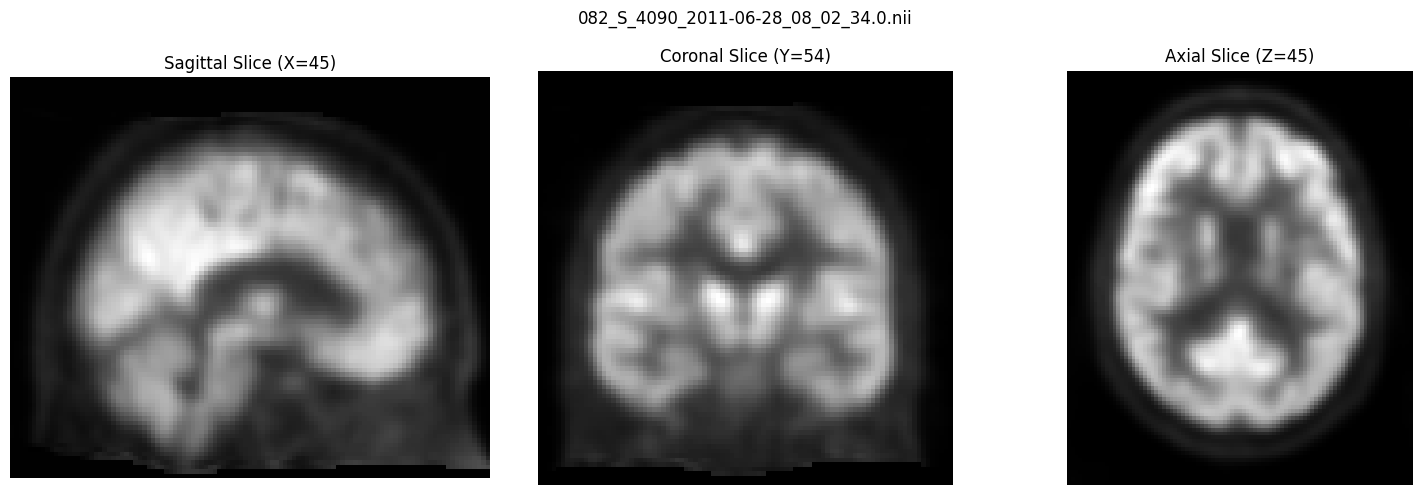

In [16]:
img_data, nifti_obj = view_random_image("/home/diogommiranda/tese/datasets/minmax/nc_ad/train/", "nc")

Image path: /home/diogommiranda/tese/datasets/mni_reg/smci_pmci/train/smci/023_S_2068_2012-10-18_12_32_48.0.nii
Image name: 023_S_2068_2012-10-18_12_32_48.0.nii
Image class: smci
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-0.03351401025429368, 2.9502401540521532]


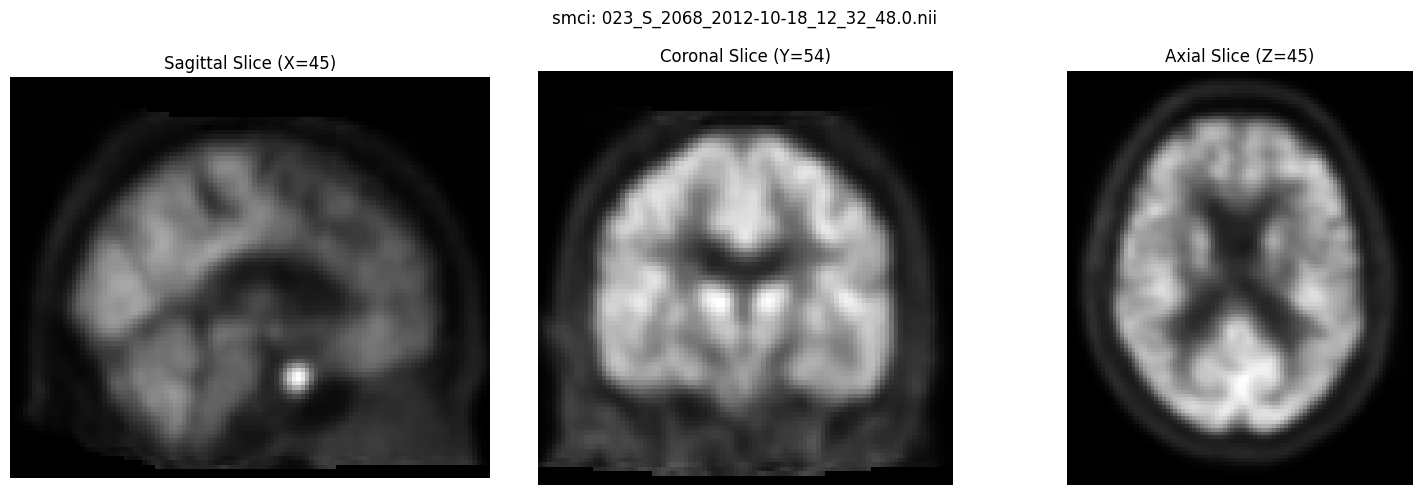

In [ ]:
# Scan with the maximum intensity value for the mni_reg dataset
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/mni_reg/smci_pmci/train/", "023_S_2068", "2012-10-18")

Image path: /home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/ad/021_S_0343_2006-10-25_10_20_48.0.nii
Image name: 021_S_0343_2006-10-25_10_20_48.0.nii
Image class: ad
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-0.4134917953342665, 1.9808099046713323]


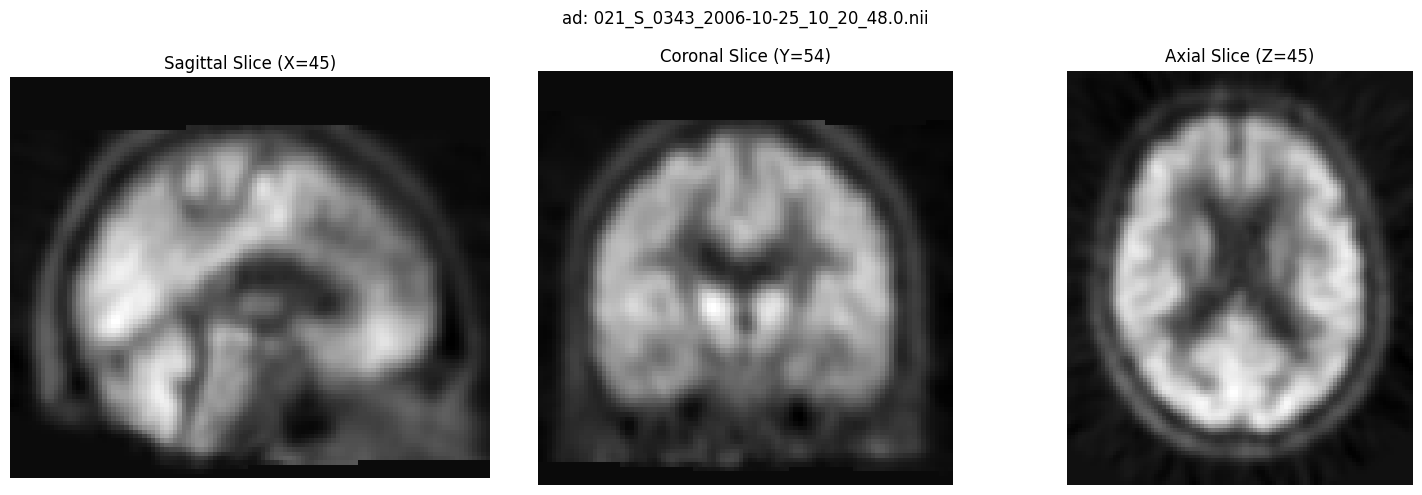

In [ ]:
# Scan with the minimum intensity value for the mni_reg dataset
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/", "021_S_0343", "2006-10-25")

Image path: /home/diogommiranda/tese/datasets/mni_reg/nc_ad/test/nc/123_S_0113_2011-03-09_09_55_03.0.nii
Image name: 123_S_0113_2011-03-09_09_55_03.0.nii
Image class: nc
Image shape: (91, 109, 91)
Data type: float64
Value range: [-0.025561912611010484, 2.025237373120035]

Image path: /home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/nc/073_S_4155_2011-08-19_14_37_37.0.nii
Image name: 073_S_4155_2011-08-19_14_37_37.0.nii
Image class: nc
Image shape: (91, 109, 91)
Data type: float64
Value range: [-0.0006207403494045138, 1.6904311565158423]



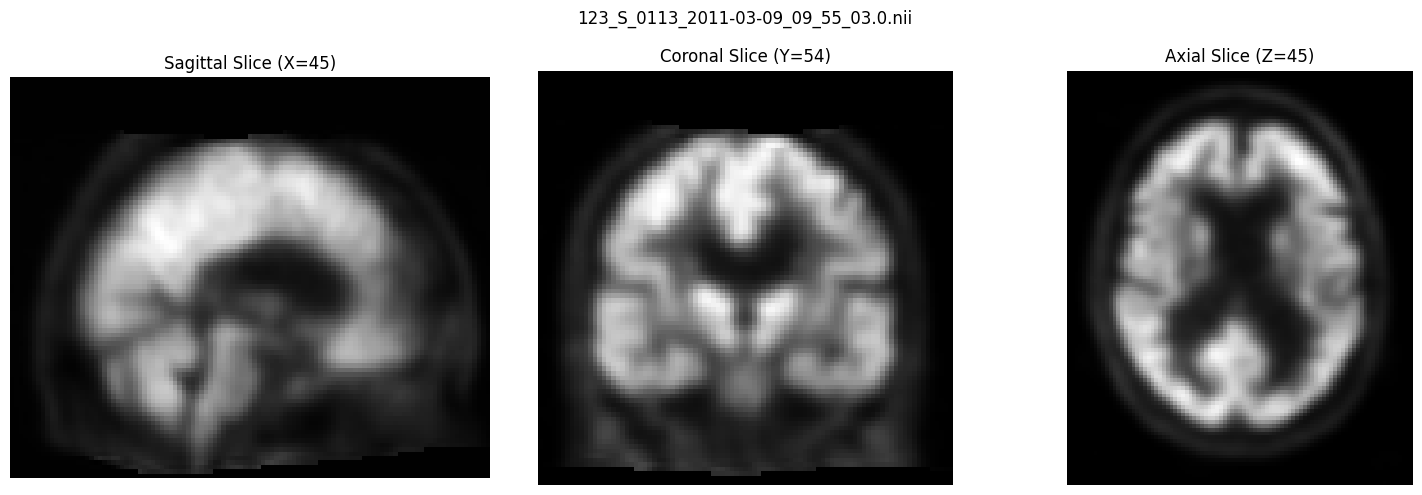

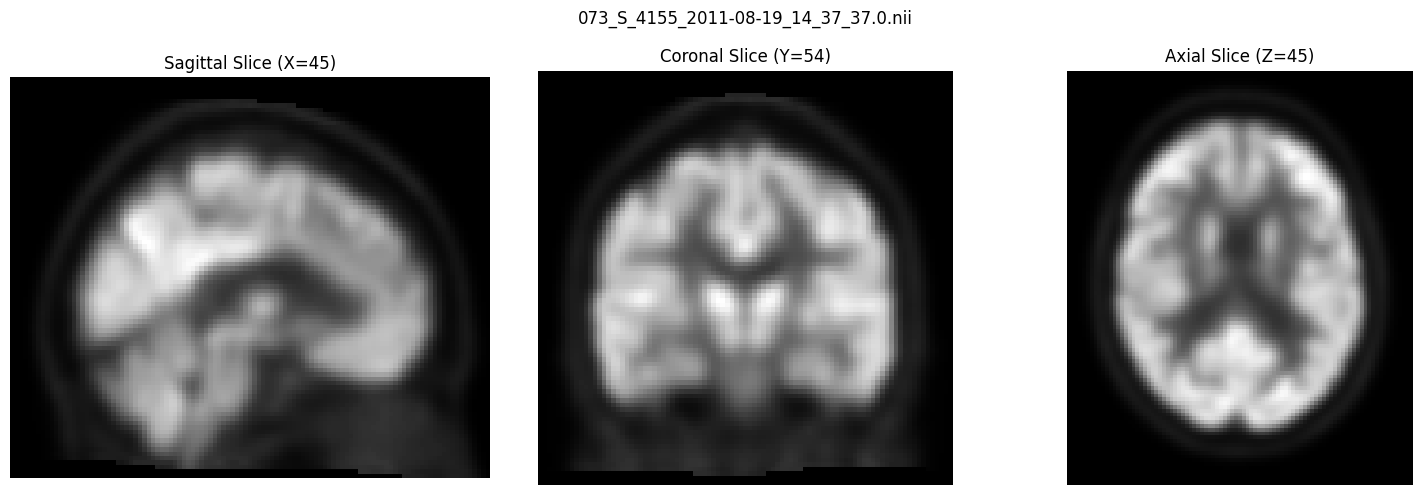

In [ ]:
# Comparing subjects of the same class
img_data, nifti_obj = view_random_image("/home/diogommiranda/tese/datasets/mni_reg/", "123_S_0113")
img_data, nifti_obj = view_random_image("/home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/", "nc")

Image path: /home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/nc/003_S_0907_2010-12-13_14_15_01.0.nii
Image name: 003_S_0907_2010-12-13_14_15_01.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-6.083077096263878e-05, 1.993241872132785]
Image path: /home/diogommiranda/tese/datasets/minmax/nc_ad/train/nc/003_S_0907_2010-12-13_14_15_01.0.nii
Image name: 003_S_0907_2010-12-13_14_15_01.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [0.12287815734453034, 0.7154915280625573]
Image path: /home/diogommiranda/tese/datasets/zscore/nc_ad/train/nc/003_S_0907_2010-12-13_14_15_01.0.nii
Image name: 003_S_0907_2010-12-13_14_15_01.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-0.6715108806565695, 1.993241872132785]


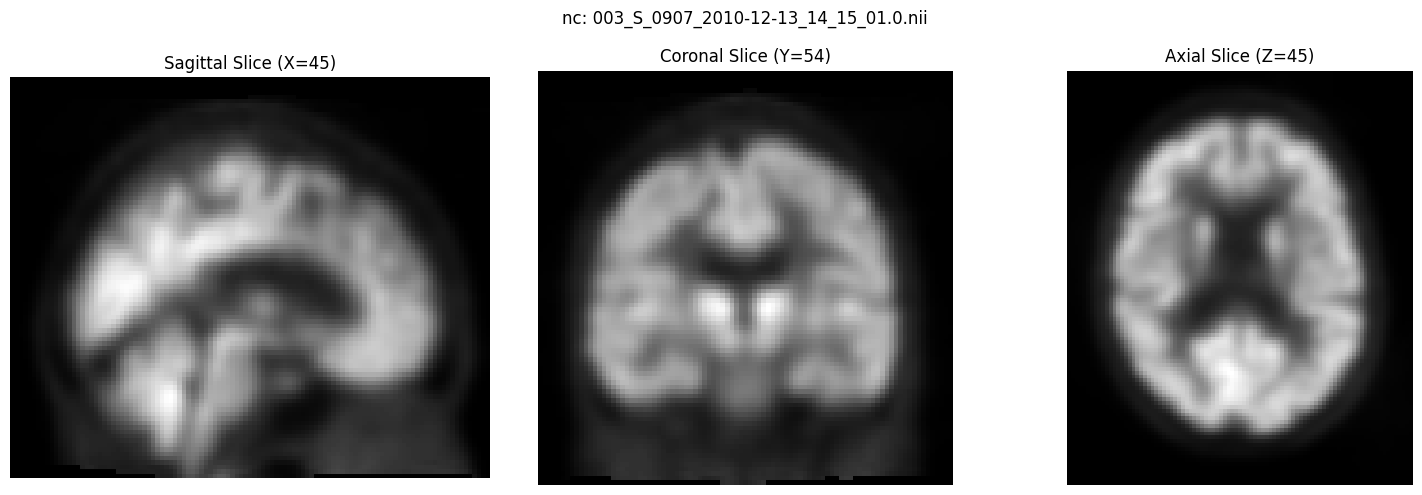

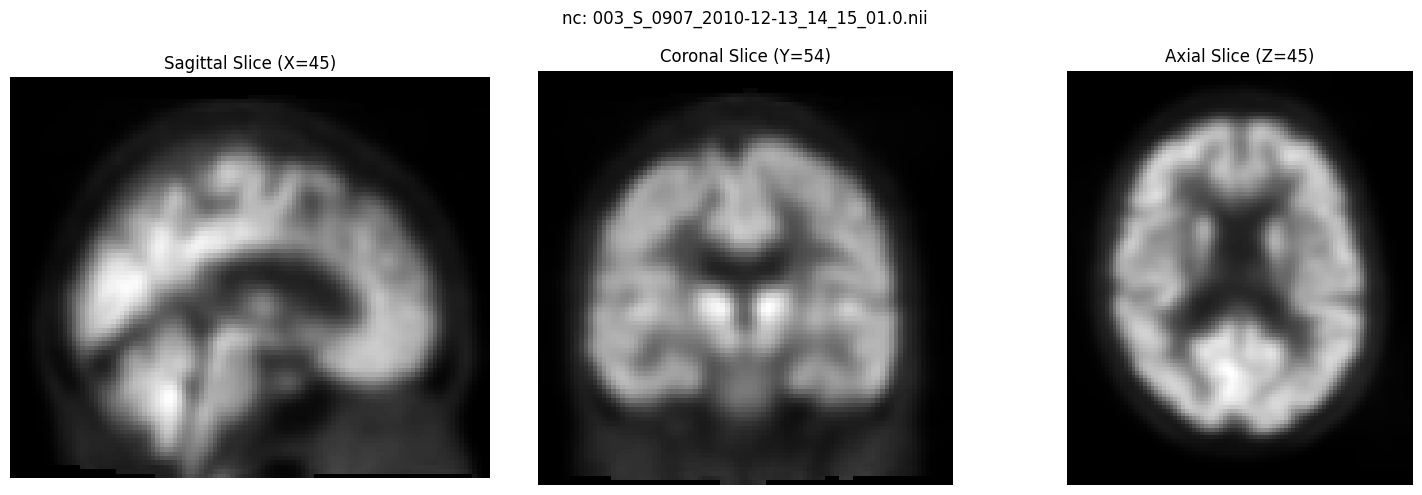

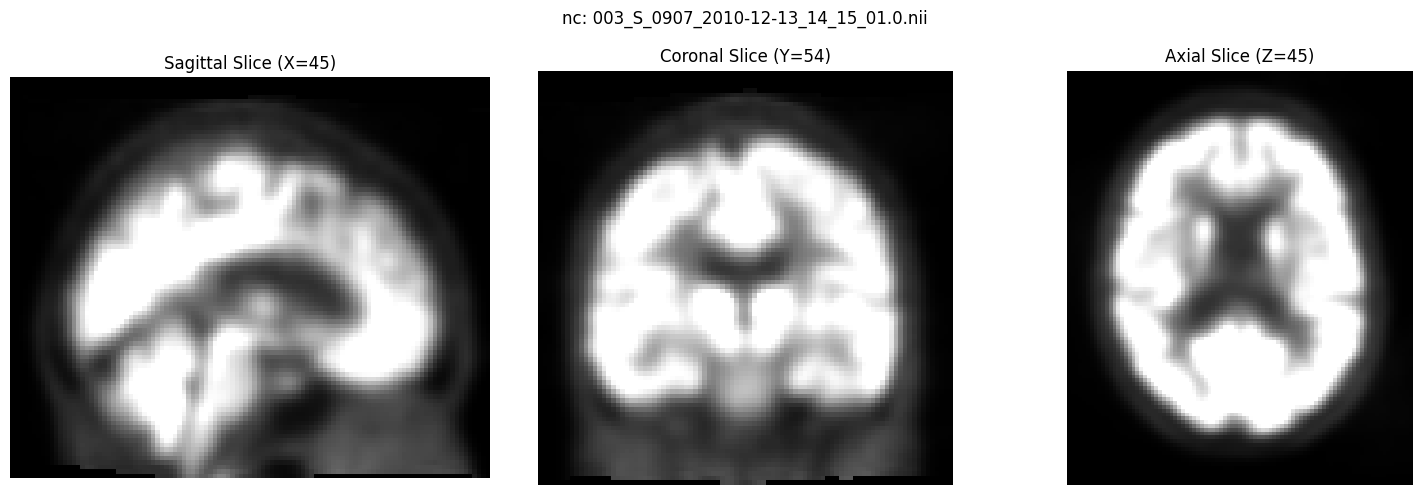

In [ ]:
# Comparison of same scan with different different normalization methods
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/mni_reg/nc_ad/", subject_id = "003_S_0907", date = "2010-12-13")
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/minmax/nc_ad/", subject_id = "003_S_0907", date = "2010-12-13")
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/zscore/nc_ad/", subject_id = "003_S_0907", date = "2010-12-13")

Image path: /home/diogommiranda/tese/datasets/mni_reg/nc_ad/train/nc/137_S_0686_2009-07-29_10_45_26.0.nii
Image name: 137_S_0686_2009-07-29_10_45_26.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-0.18646934287971817, 2.0072407878251397]
Image path: /home/diogommiranda/tese/datasets/minmax/nc_ad/train/nc/137_S_0686_2009-07-29_10_45_26.0.nii
Image name: 137_S_0686_2009-07-29_10_45_26.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [0.06750631269824225, 0.719658948801225]
Image path: /home/diogommiranda/tese/datasets/zscore/nc_ad/train/nc/137_S_0686_2009-07-29_10_45_26.0.nii
Image name: 137_S_0686_2009-07-29_10_45_26.0.nii
Image class: nc
Image shape: (91, 109, 91)
ImageData Type: float64
Value Range: [-1.1134253535419703, 2.0072407878251397]


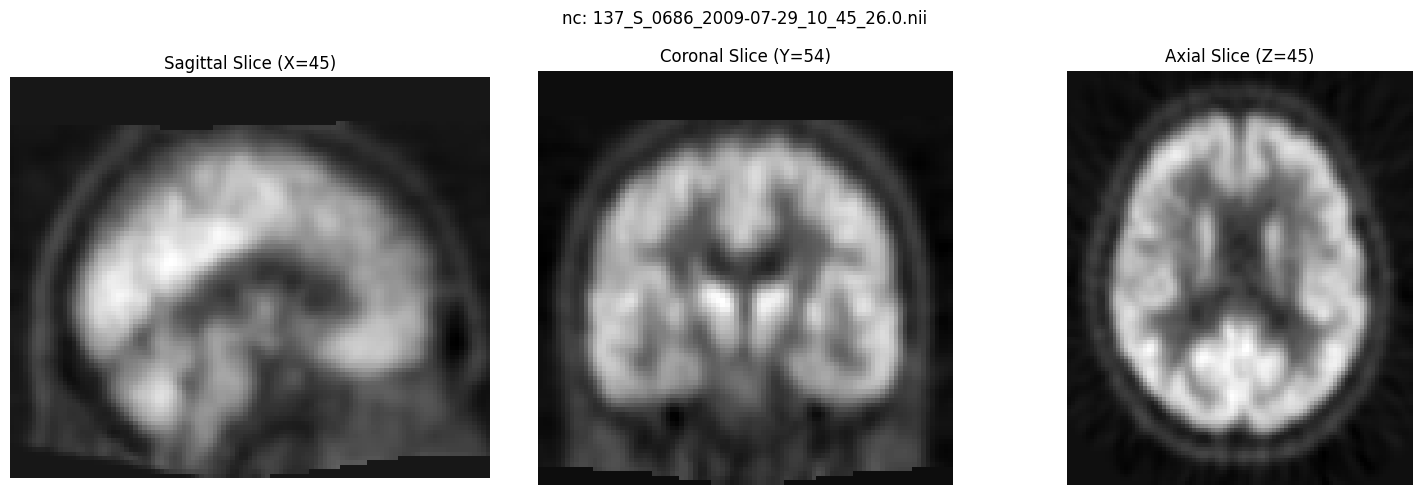

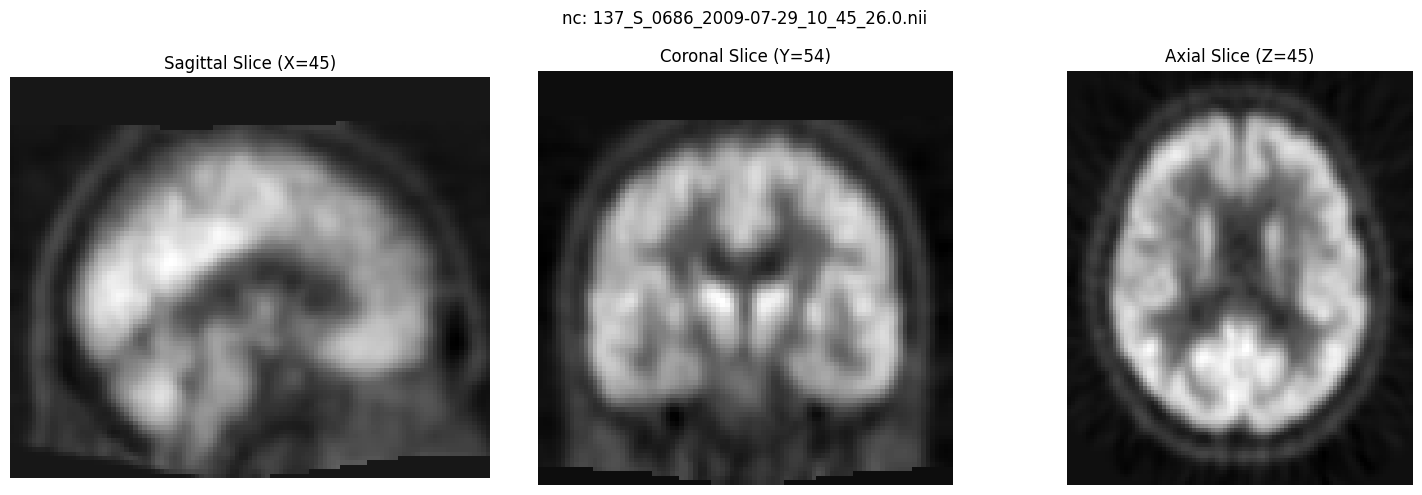

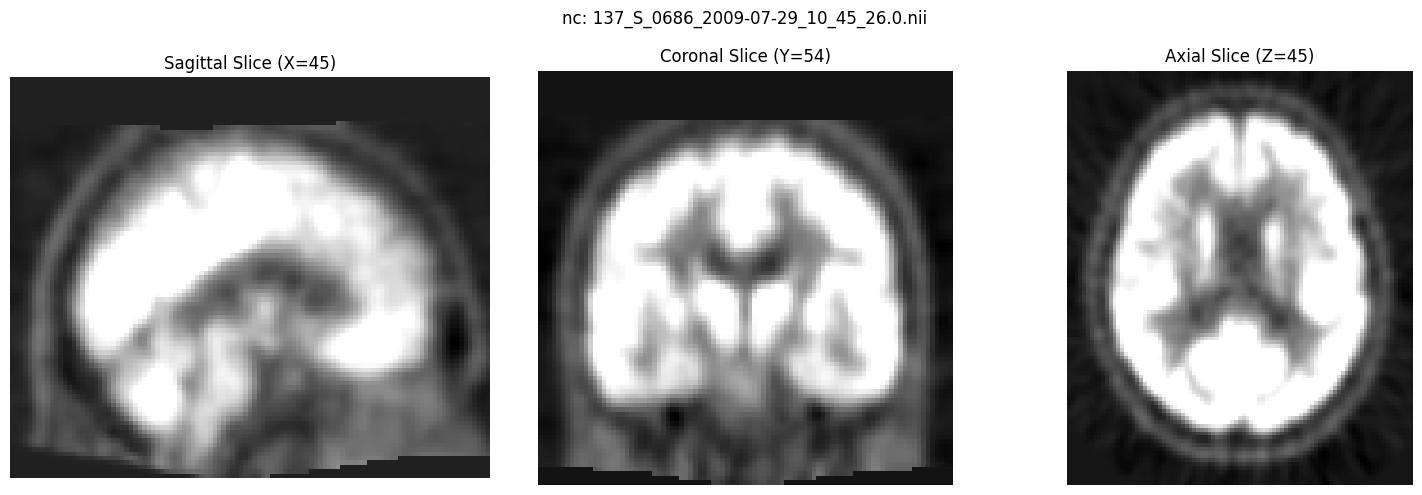

In [ ]:
# Comparison of same scan with different different normalization methods for a Minority Protocol
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/mni_reg/nc_ad/", subject_id = "137_S_0686", date = "2009-07-29")
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/minmax/nc_ad/", subject_id = "137_S_0686", date = "2009-07-29")
img_data, nifti_obj = view_image("/home/diogommiranda/tese/datasets/zscore/nc_ad/", subject_id = "137_S_0686", date = "2009-07-29")

## 2. Build the Train and Test datasets

In [ ]:
NORMALIZATION = "minmax" # Choose intensity normalization method: "minmax", "zscore"
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"

In [ ]:
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET

BATCH_SIZE = 16 # Set batch size for training
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images

# Create train dataset
train_data = create_dataset(
    data_dir=DATA_DIR,
    split='train',
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed
)

# Create test dataset
test_data = create_dataset(
        data_dir=DATA_DIR,
        split='test',
        batch_size=BATCH_SIZE,
        volume_shape=VOLUME_SHAPE,
        is_training=False,
        seed=None
    )

# Check if the datasets were successfully created
if train_data is None:
    print("ERROR: Train dataset could not be created.")
    exit()
if test_data is None:
    print("ERROR: Test dataset could not be created.")
    exit()

Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/train...
Found 575 files for class 'smci'
Found 312 files for class 'pmci'
Dataset created for split 'train'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/test...
Found 143 files for class 'smci'
Found 80 files for class 'pmci'
Dataset created for split 'test'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [20]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [21]:
# Get a sample of the train data batch
images, labels = next(iter(train_data)) # get the 'next' batch of images/labels
len(images), len(labels)

2025-04-07 18:21:27.083965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


(16, 16)

In [22]:
# Get the first two images
images[:2], images[0].shape

(<tf.Tensor: shape=(2, 91, 109, 91, 1), dtype=float32, numpy=
 array([[[[[0.12291747],
           [0.12291747],
           [0.12291747],
           ...,
           [0.12291747],
           [0.12291747],
           [0.12291747]],
 
          [[0.12291747],
           [0.12291747],
           [0.12291747],
           ...,
           [0.12291747],
           [0.12291747],
           [0.12291747]],
 
          [[0.12291747],
           [0.12291747],
           [0.12291747],
           ...,
           [0.12291747],
           [0.12291747],
           [0.12291747]],
 
          ...,
 
          [[0.12291747],
           [0.12291747],
           [0.12291747],
           ...,
           [0.12291747],
           [0.12291747],
           [0.12291747]],
 
          [[0.12291747],
           [0.12291747],
           [0.12291747],
           ...,
           [0.12291747],
           [0.12291747],
           [0.12291747]],
 
          [[0.12291747],
           [0.12291747],
           [0.12291747],
 

In [23]:
y_train = []
for batch in train_data.as_numpy_iterator():
    labels_in_batch = batch[1]
    y_train.append(labels_in_batch)
y_train

2025-04-07 18:21:32.142328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 1., 1., 0., 0., 0., 1., 

## 3. Train a ResNet18 Model

In [ ]:
NORMALIZATION = "minmax" # Determine the intensity normalization to use: "minmax", "zscore"
DATASET = "smci_pmci" # Determine the dataset to use: "smci_pmci" or "nc_ad"

In [5]:
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET

BATCH_SIZE = 16 # Set batch size for training
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images

# Create train dataset
train_data = create_dataset(
    data_dir=DATA_DIR,
    split='train',
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed
)

# Create test dataset
test_data = create_dataset(
        data_dir=DATA_DIR,
        split='test',
        batch_size=BATCH_SIZE,
        volume_shape=VOLUME_SHAPE,
        is_training=False,
        seed=None
    )

# Check if the datasets were successfully created
if train_data is None:
    print("ERROR: Train dataset could not be created.")
    exit()
if test_data is None:
    print("ERROR: Test dataset could not be created.")
    exit()

Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/train...
Found 575 files for class 'smci'
Found 312 files for class 'pmci'


2025-04-08 12:30:18.804492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-08 12:30:18.919690: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-08 12:30:18.919765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-08 12:30:18.921713: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-08 12:30:18.921763: I external/local_xla/xla/stream_executor

Dataset created for split 'train'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/test...
Found 143 files for class 'smci'
Found 80 files for class 'pmci'
Dataset created for split 'test'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


### Finding the ideal learning rate

In [ ]:
# Create the ResNet18 model
model = Resnet3DBuilder.build_resnet_18((91, 109, 91, 1), 1, reg_factor=0)

num_epochs = 20
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Create the learning rate monitoring callback
# callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/3))

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data, verbose=1, callbacks=[lr_scheduler])

here CHANNELS last
Epoch 1/20


2025-04-07 18:58:02.033577: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 589ms/step - accuracy: 0.2158 - loss: 1.1651 - val_accuracy: 0.3587 - val_loss: 0.9598 - learning_rate: 1.0000e-08
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.2198 - loss: 1.1621 - val_accuracy: 0.3587 - val_loss: 0.9001 - learning_rate: 2.1544e-08
Epoch 3/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.0000e+00 - loss: 1.3270

2025-04-07 18:58:39.595739: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2006 - loss: 1.1738

2025-04-07 18:58:45.265063: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.2058 - loss: 1.1698 - val_accuracy: 0.3632 - val_loss: 0.8804 - learning_rate: 4.6416e-08
Epoch 4/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.0000e+00 - loss: 1.3214

2025-04-07 18:58:46.197600: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.2196 - loss: 1.1567

2025-04-07 18:58:53.502924: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.2242 - loss: 1.1532 - val_accuracy: 0.5471 - val_loss: 0.8708 - learning_rate: 1.0000e-07
Epoch 5/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.0000e+00 - loss: 1.3077

2025-04-07 18:58:54.429710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.2078 - loss: 1.1543

2025-04-07 18:59:00.162622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.2128 - loss: 1.1506 - val_accuracy: 0.6188 - val_loss: 0.8679 - learning_rate: 2.1544e-07
Epoch 6/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.0000e+00 - loss: 1.2847

2025-04-07 18:59:01.091932: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.2139 - loss: 1.1298

2025-04-07 18:59:06.825823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.2186 - loss: 1.1264 - val_accuracy: 0.6054 - val_loss: 0.8692 - learning_rate: 4.6416e-07
Epoch 7/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.0000e+00 - loss: 1.2372

2025-04-07 18:59:07.756792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2076 - loss: 1.0930

2025-04-07 18:59:13.360325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.2126 - loss: 1.0897 - val_accuracy: 0.4619 - val_loss: 0.8741 - learning_rate: 1.0000e-06
Epoch 8/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.0000e+00 - loss: 1.1486

2025-04-07 18:59:14.278096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.2148 - loss: 1.0158

2025-04-07 18:59:19.892495: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.2195 - loss: 1.0130 - val_accuracy: 0.3677 - val_loss: 0.8783 - learning_rate: 2.1544e-06
Epoch 9/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.0000e+00 - loss: 0.9918

2025-04-07 18:59:20.808048: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.3419 - loss: 0.9056

2025-04-07 18:59:27.968617: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 292ms/step - accuracy: 0.3495 - loss: 0.9040 - val_accuracy: 0.4036 - val_loss: 0.8768 - learning_rate: 4.6416e-06
Epoch 10/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.8125 - loss: 0.7900

2025-04-07 18:59:28.944308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.7968 - loss: 0.7732

2025-04-07 18:59:34.686169: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.7947 - loss: 0.7730 - val_accuracy: 0.4305 - val_loss: 0.8748 - learning_rate: 1.0000e-05
Epoch 11/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.8125 - loss: 0.7106

2025-04-07 18:59:35.631096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8460 - loss: 0.6760

2025-04-07 18:59:41.431304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.8453 - loss: 0.6750 - val_accuracy: 0.3767 - val_loss: 0.8865 - learning_rate: 2.1544e-05
Epoch 12/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.5625 - loss: 0.8669

2025-04-07 18:59:42.350777: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.8065 - loss: 0.6211

2025-04-07 18:59:48.133959: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.8091 - loss: 0.6169 - val_accuracy: 0.6682 - val_loss: 0.7574 - learning_rate: 4.6416e-05
Epoch 13/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.6250 - loss: 0.9889

2025-04-07 18:59:49.084342: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7800 - loss: 0.6898

2025-04-07 18:59:54.876044: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 240ms/step - accuracy: 0.7822 - loss: 0.6850 - val_accuracy: 0.6457 - val_loss: 1.2940 - learning_rate: 1.0000e-04
Epoch 14/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.5938 - loss: 1.1628

2025-04-07 18:59:55.821610: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7755 - loss: 0.7058

2025-04-07 19:00:03.178530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.7784 - loss: 0.6998 - val_accuracy: 0.6233 - val_loss: 2.0294 - learning_rate: 2.1544e-04
Epoch 15/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.4688 - loss: 1.1991

2025-04-07 19:00:04.103022: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7199 - loss: 0.7672

2025-04-07 19:00:09.703663: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7214 - loss: 0.7641 - val_accuracy: 0.3587 - val_loss: 8.8539 - learning_rate: 4.6416e-04
Epoch 16/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.5000 - loss: 1.2027

2025-04-07 19:00:10.632222: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7633 - loss: 0.7216

2025-04-07 19:00:16.216436: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.7644 - loss: 0.7186 - val_accuracy: 0.6413 - val_loss: 5.9537 - learning_rate: 0.0010
Epoch 17/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.5312 - loss: 1.1139

2025-04-07 19:00:17.145875: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6974 - loss: 0.8104

2025-04-07 19:00:22.796297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.6955 - loss: 0.8112 - val_accuracy: 0.6413 - val_loss: nan - learning_rate: 0.0022
Epoch 18/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.0000e+00 - loss: 0.9804

2025-04-07 19:00:23.724415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6373 - loss: 0.8567

2025-04-07 19:00:29.356319: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.6378 - loss: 0.8574 - val_accuracy: 0.3587 - val_loss: 10.3720 - learning_rate: 0.0046
Epoch 19/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6250 - loss: 0.9742

2025-04-07 19:00:30.247743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7324 - loss: 0.7736

2025-04-07 19:00:37.368033: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - accuracy: 0.7287 - loss: 0.7758 - val_accuracy: 0.6413 - val_loss: nan - learning_rate: 0.0100
Epoch 20/20
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.9062 - loss: 0.7661

2025-04-07 19:00:38.302823: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8106 - loss: 0.7666

2025-04-07 19:00:43.916421: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.8081 - loss: 0.7676 - val_accuracy: 0.4305 - val_loss: nan - learning_rate: 0.0215


Text(0.5, 1.0, 'Learning rate vs. loss')

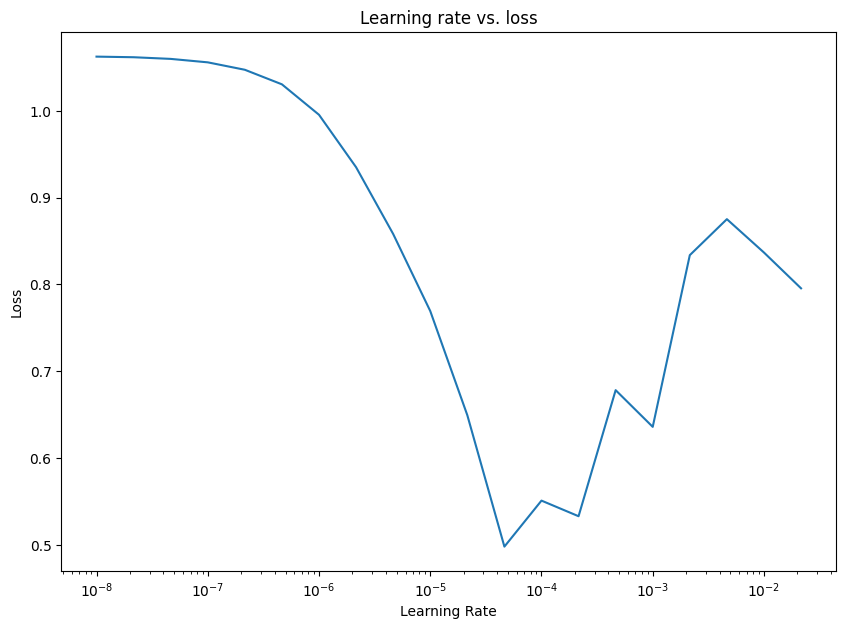

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-8 * (10 ** (np.arange(num_epochs)/3))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss")

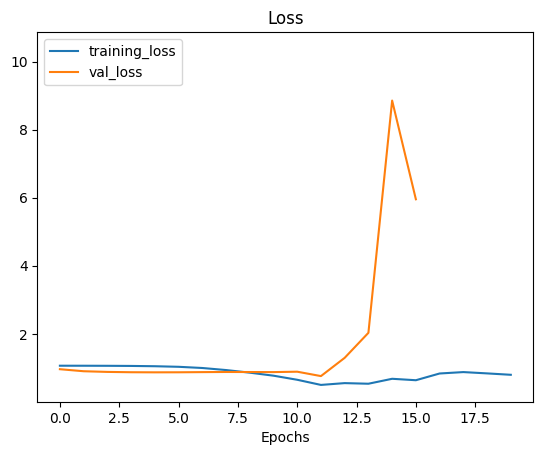

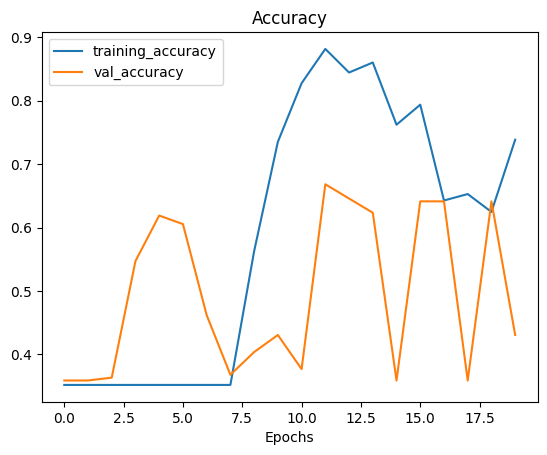

In [ ]:
plot_loss_curves(history)

### Fitting the model with the ideal learning rate

In [ ]:
# Create the ResNet18 model
model18 = Resnet3DBuilder.build_resnet_18((91, 109, 91, 1), 1, reg_factor=0)

# Compile the model
model18.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
              metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
# callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/5))

here CHANNELS last


In [ ]:
history18 = model18.fit(train_data, epochs=50, validation_data=test_data, verbose=1, callbacks=[early_stopping])

Epoch 1/50


I0000 00:00:1744107631.102608    3222 service.cc:145] XLA service 0x7faee0001640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744107631.102657    3222 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-08 11:20:31.471578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-08 11:20:32.458102: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-04-08 11:20:41.017307: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1744107647.477112    3222 device_compiler.h:188] Compiled cluster using XLA

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8052 - loss: 0.6889

2025-04-08 11:20:59.596103: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1744107666.745999    3223 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_5', 200 bytes spill stores, 200 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_convert_reduce_fusion_7', 204 bytes spill stores, 204 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 352 bytes spill stores, 352 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_15', 76 bytes spill stores, 76 bytes spill loads



56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 490ms/step - accuracy: 0.7997 - loss: 0.6938 - val_accuracy: 0.6413 - val_loss: 0.8402
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7846 - loss: 0.6840

2025-04-08 11:21:21.453869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.7823 - loss: 0.6854 - val_accuracy: 0.6413 - val_loss: 0.8399
Epoch 3/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step - accuracy: 1.0000 - loss: 0.5943

2025-04-08 11:21:22.740185: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8325 - loss: 0.6654

2025-04-08 11:21:29.365060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8280 - loss: 0.6676 - val_accuracy: 0.6413 - val_loss: 0.8423
Epoch 4/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9375 - loss: 0.6283

2025-04-08 11:21:30.602219: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8627 - loss: 0.6532

2025-04-08 11:21:38.053636: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8600 - loss: 0.6542 - val_accuracy: 0.6413 - val_loss: 0.8455
Epoch 5/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.8750 - loss: 0.6588

2025-04-08 11:21:39.338286: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8708 - loss: 0.6235

2025-04-08 11:21:45.836172: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.8689 - loss: 0.6239 - val_accuracy: 0.7265 - val_loss: 0.8450
Epoch 6/50
 2/56 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8125 - loss: 0.6365

2025-04-08 11:21:46.845845: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8419 - loss: 0.6042

2025-04-08 11:21:53.063291: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.8417 - loss: 0.6035 - val_accuracy: 0.7713 - val_loss: 0.8275
Epoch 7/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.8125 - loss: 0.6332

2025-04-08 11:21:54.027629: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8662 - loss: 0.5667

2025-04-08 11:22:00.565452: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.8667 - loss: 0.5654 - val_accuracy: 0.6278 - val_loss: 0.8150
Epoch 8/50
 2/56 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8594 - loss: 0.6421

2025-04-08 11:22:01.601966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8794 - loss: 0.5335

2025-04-08 11:22:08.356960: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8801 - loss: 0.5318 - val_accuracy: 0.6457 - val_loss: 0.7874
Epoch 9/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7500 - loss: 0.6225

2025-04-08 11:22:09.344116: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8892 - loss: 0.4893

2025-04-08 11:22:15.804122: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.8905 - loss: 0.4868 - val_accuracy: 0.7265 - val_loss: 0.7160
Epoch 10/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.6875 - loss: 0.6827

2025-04-08 11:22:16.798906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9099 - loss: 0.4558

2025-04-08 11:22:23.172757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9108 - loss: 0.4536 - val_accuracy: 0.6816 - val_loss: 0.7532
Epoch 11/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.8125 - loss: 0.7110

2025-04-08 11:22:24.162490: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9193 - loss: 0.4423

2025-04-08 11:22:30.597855: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9204 - loss: 0.4393 - val_accuracy: 0.7444 - val_loss: 0.6935
Epoch 12/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8125 - loss: 0.5569

2025-04-08 11:22:31.556283: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9172 - loss: 0.4084

2025-04-08 11:22:38.547009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9186 - loss: 0.4056 - val_accuracy: 0.5740 - val_loss: 0.9416
Epoch 13/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8750 - loss: 0.5994

2025-04-08 11:22:39.600211: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9342 - loss: 0.3865

2025-04-08 11:22:45.980746: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9353 - loss: 0.3837 - val_accuracy: 0.8117 - val_loss: 0.6139
Epoch 14/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.8125 - loss: 0.5279

2025-04-08 11:22:46.954910: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9397 - loss: 0.3567

2025-04-08 11:22:53.290860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9412 - loss: 0.3540 - val_accuracy: 0.7937 - val_loss: 0.6613
Epoch 15/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.8750 - loss: 0.5203

2025-04-08 11:22:54.266607: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9325 - loss: 0.3595

2025-04-08 11:23:00.646225: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9340 - loss: 0.3566 - val_accuracy: 0.8117 - val_loss: 0.6471
Epoch 16/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8750 - loss: 0.5259

2025-04-08 11:23:01.671186: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9670 - loss: 0.3205

2025-04-08 11:23:08.066622: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9677 - loss: 0.3182 - val_accuracy: 0.7937 - val_loss: 0.6891
Epoch 17/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.8750 - loss: 0.4931

2025-04-08 11:23:09.044716: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9665 - loss: 0.3197 - val_accuracy: 0.7803 - val_loss: 0.7097
Epoch 18/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9868 - loss: 0.2985

2025-04-08 11:23:23.424330: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.9870 - loss: 0.2964 - val_accuracy: 0.7937 - val_loss: 0.6951
Epoch 19/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9938 - loss: 0.2901 - val_accuracy: 0.8206 - val_loss: 0.7007
Epoch 20/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9924 - loss: 0.2875

2025-04-08 11:23:37.928664: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9926 - loss: 0.2853 - val_accuracy: 0.7982 - val_loss: 0.7343
Epoch 21/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9929 - loss: 0.2814 - val_accuracy: 0.7937 - val_loss: 0.7694
Epoch 22/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9983 - loss: 0.2720

2025-04-08 11:23:55.343816: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9983 - loss: 0.2712 - val_accuracy: 0.7848 - val_loss: 0.7660
Epoch 23/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9974 - loss: 0.2746

2025-04-08 11:24:02.159236: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9974 - loss: 0.2728 - val_accuracy: 0.7892 - val_loss: 0.7935
Epoch 24/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.2513

2025-04-08 11:24:09.607640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 1.0000 - loss: 0.2498 - val_accuracy: 0.8072 - val_loss: 0.7738
Epoch 25/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9957 - loss: 0.2594

2025-04-08 11:24:19.103324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9957 - loss: 0.2587 - val_accuracy: 0.8161 - val_loss: 0.7591
Epoch 26/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9959 - loss: 0.2609 - val_accuracy: 0.7982 - val_loss: 0.7859
Epoch 27/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 0.2536 - val_accuracy: 0.7758 - val_loss: 0.8895
Epoch 28/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9956 - loss: 0.2470 - val_accuracy: 0.7848 - val_loss: 0.9146
Epoch 29/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9988 - loss: 0.2467 - val_accuracy: 0.7803 - val_loss: 0.8980
Epoch 30/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 0.2416 - val_accuracy: 0.7758 - val_loss: 0.8621
Epoch 31/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 0.2327 - val_accuracy: 0.7668 - val_loss: 1.0813
Epoch 32/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 0.2410 - val_accuracy: 0.8027

2025-04-08 11:25:32.038795: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 1.0000 - loss: 0.2285 - val_accuracy: 0.7713 - val_loss: 0.9747
Epoch 35/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.2304

2025-04-08 11:25:38.967920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 0.2293 - val_accuracy: 0.7937 - val_loss: 0.8671
Epoch 36/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9999 - loss: 0.2288 - val_accuracy: 0.8117 - val_loss: 0.8645
Epoch 37/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 1.0000 - loss: 0.2260 - val_accuracy: 0.7982 - val_loss: 0.8546
Epoch 38/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 1.0000 - loss: 0.2270

2025-04-08 11:26:04.076155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 0.2265 - val_accuracy: 0.7848 - val_loss: 0.9116
Epoch 39/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 0.2203 - val_accuracy: 0.8206 - val_loss: 0.8209
Epoch 40/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9965 - loss: 0.2260 - val_accuracy: 0.7848 - val_loss: 0.8952
Epoch 41/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 1.0000 - loss: 0.2277 - val_accuracy: 0.7892 - val_loss: 0.9416
Epoch 42/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 0.2197 - val_accuracy: 0.7848 - val_loss: 0.9573
Epoch 43/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 1.0000 - loss: 0.2218 - val_accuracy: 0.8027 - val_loss: 0.8632
Epoch 44/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 0.2198 - val_accuracy: 0.7534 - val_loss: 1.1697
Epoch 45/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.2185

2025-04-08 11:26:58.222289: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 0.2176 - val_accuracy: 0.7848 - val_loss: 0.9219
Epoch 46/50
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 0.2121

2025-04-08 11:27:06.203280: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 0.2114 - val_accuracy: 0.7892 - val_loss: 0.9989
Epoch 47/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 0.2123 - val_accuracy: 0.7892 - val_loss: 0.8536
Epoch 48/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9966 - loss: 0.2193 - val_accuracy: 0.7937 - val_loss: 0.9349
Epoch 49/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 0.2172 - val_accuracy: 0.8161 - val_loss: 0.8195


In [ ]:
model18.evaluate(test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8695 - loss: 0.5715


[0.8195025324821472, 0.8161435127258301]

In [ ]:
y_pred = model18.predict(test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step


In [18]:
y_true = []
for batch in test_data.as_numpy_iterator():
    # Assuming your dataset yields (features, labels) tuples
    # Access the labels (usually the second element, index 1)
    labels_in_batch = batch[1]
    y_true.append(labels_in_batch)
y_true = np.concatenate(y_true)
y_true

2025-04-08 11:28:29.530765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=flo

In [ ]:
class0, class1 = DATASET.split("_")
target_names = [class0, class1]
print(classification_report(y_true, y_pred.round(), target_names=target_names))

              precision    recall  f1-score   support

        smci       0.84      0.89      0.86       143
        pmci       0.77      0.69      0.73        80

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.79       223
weighted avg       0.81      0.82      0.81       223



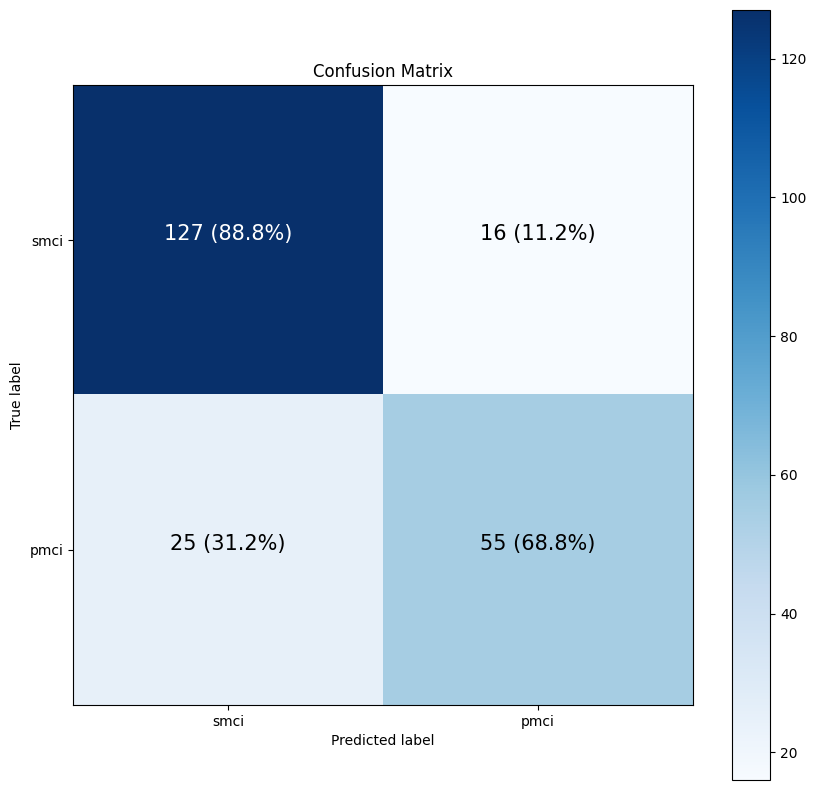

In [20]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(10, 10),
                      text_size=15)

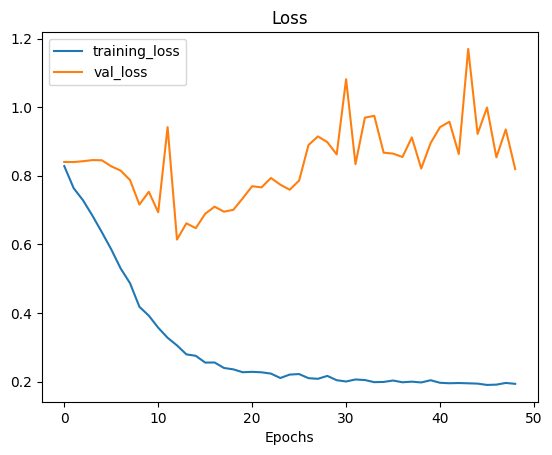

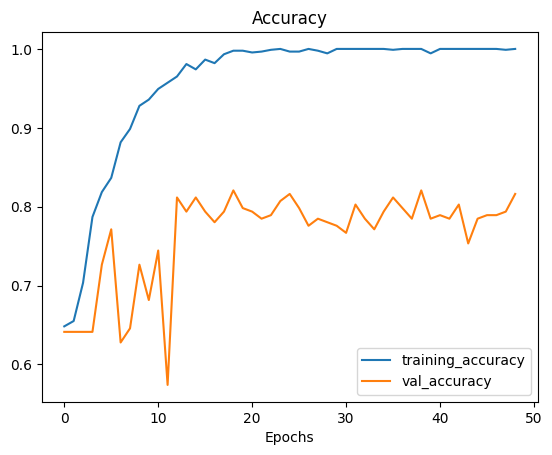

In [21]:
plot_loss_curves(history18)

### Save the model

In [ ]:
#model18.save("/home/diogommiranda/tese/models/Resnet18/smci_pmci/minmax/Resnet18_batches16.keras")

In [ ]:
#saved_model = tf.keras.models.load_model("/home/diogommiranda/tese/models/Resnet18/smci_pmci/minmax/Resnet18_batches16.keras")
#saved_model.evaluate(test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.8695 - loss: 0.5715


[0.8195025324821472, 0.8161435127258301]

## 4. Train a ResNet34 model

In [24]:
NORMALIZATION = "minmax" # Determine the intensity normalization to use: "minmax", "zscore"
DATASET = "nc_ad" # Determine the dataset to use: "smci_pmci" or "nc_ad"

In [ ]:
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET

BATCH_SIZE = 16 # Set batch size for training
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images

# Create train dataset
train_data = create_dataset(
    data_dir=DATA_DIR,
    split='train',
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed
)

# Create test dataset
test_data = create_dataset(
        data_dir=DATA_DIR,
        split='test',
        batch_size=BATCH_SIZE,
        volume_shape=VOLUME_SHAPE,
        is_training=False,
        seed=None
    )

# Check if the datasets were successfully created
if train_data is None:
    print("ERROR: Train dataset could not be created.")
    exit()
if test_data is None:
    print("ERROR: Test dataset could not be created.")
    exit()

Found classes: ['nc', 'ad']
Class map: {'nc': 0, 'ad': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/nc_ad/train...
Found 558 files for class 'nc'
Found 433 files for class 'ad'
Dataset created for split 'train'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Found classes: ['nc', 'ad']
Class map: {'nc': 0, 'ad': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/nc_ad/test...
Found 141 files for class 'nc'
Found 106 files for class 'ad'
Dataset created for split 'test'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


### Finding the ideal learning rate

In [ ]:
# Create the ResNet34 model
model = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=0)

num_epochs = 20
# Compile the model
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/3))

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data, verbose=1, callbacks=[lr_scheduler])

here CHANNELS last
Epoch 1/20


I0000 00:00:1744108392.538693    3223 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8__7', 2148 bytes spill stores, 1984 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads



61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2447 - loss: 0.9796

I0000 00:00:1744108422.844118    3223 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8__7', 2148 bytes spill stores, 1984 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads



62/62 ━━━━━━━━━━━━━━━━━━━━ 62s 569ms/step - accuracy: 0.2508 - loss: 0.9775 - val_accuracy: 0.4291 - val_loss: 0.9571 - learning_rate: 1.0000e-08
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.2667 - loss: 0.9700 - val_accuracy: 0.4291 - val_loss: 0.9622 - learning_rate: 2.1544e-08
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2443 - loss: 0.9761

2025-04-08 11:34:08.203865: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.2474 - loss: 0.9751 - val_accuracy: 0.4291 - val_loss: 0.9680 - learning_rate: 4.6416e-08
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.2691 - loss: 0.9606 - val_accuracy: 0.4291 - val_loss: 0.9711 - learning_rate: 1.0000e-07
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2592 - loss: 0.9508

2025-04-08 11:34:28.714485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.2620 - loss: 0.9498 - val_accuracy: 0.4291 - val_loss: 0.9735 - learning_rate: 2.1544e-07
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2704 - loss: 0.9261

2025-04-08 11:34:40.365139: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.2736 - loss: 0.9252 - val_accuracy: 0.4291 - val_loss: 0.9667 - learning_rate: 4.6416e-07
Epoch 7/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.0000e+00 - loss: 0.9629

2025-04-08 11:34:41.544849: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4277 - loss: 0.8803

2025-04-08 11:34:50.733469: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.4317 - loss: 0.8795 - val_accuracy: 0.4291 - val_loss: 0.9280 - learning_rate: 1.0000e-06
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7082 - loss: 0.8117

2025-04-08 11:35:01.212310: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.7093 - loss: 0.8111 - val_accuracy: 0.4534 - val_loss: 0.8435 - learning_rate: 2.1544e-06
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7919 - loss: 0.7081

2025-04-08 11:35:11.836378: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.7927 - loss: 0.7070 - val_accuracy: 0.7166 - val_loss: 0.7097 - learning_rate: 4.6416e-06
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8133 - loss: 0.6222

2025-04-08 11:35:22.440388: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.8143 - loss: 0.6203 - val_accuracy: 0.8826 - val_loss: 0.4649 - learning_rate: 1.0000e-05
Epoch 11/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.5625 - loss: 1.1830

2025-04-08 11:35:23.636640: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8508 - loss: 0.5637

2025-04-08 11:35:32.893412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.8519 - loss: 0.5611 - val_accuracy: 0.8502 - val_loss: 0.5227 - learning_rate: 2.1544e-05
Epoch 12/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.5000 - loss: 1.2050

2025-04-08 11:35:34.111732: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7820 - loss: 0.6715

2025-04-08 11:35:42.918059: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.7834 - loss: 0.6686 - val_accuracy: 0.8947 - val_loss: 0.4593 - learning_rate: 4.6416e-05
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7780 - loss: 0.6733

2025-04-08 11:35:54.952005: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.7797 - loss: 0.6699 - val_accuracy: 0.4372 - val_loss: 2.3798 - learning_rate: 1.0000e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7548 - loss: 0.7075

2025-04-08 11:36:07.161267: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.7560 - loss: 0.7052 - val_accuracy: 0.5911 - val_loss: 1.3571 - learning_rate: 2.1544e-04
Epoch 15/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.3750 - loss: 1.6705

2025-04-08 11:36:08.376008: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7854 - loss: 0.6764

2025-04-08 11:36:17.275659: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7864 - loss: 0.6743 - val_accuracy: 0.5749 - val_loss: 6.7578 - learning_rate: 4.6416e-04
Epoch 16/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 14s 230ms/step - accuracy: 0.5625 - loss: 0.9109

2025-04-08 11:36:18.506613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8476 - loss: 0.5348 - val_accuracy: 0.5870 - val_loss: 4.8035 - learning_rate: 0.0010
Epoch 17/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8015 - loss: 0.6595

2025-04-08 11:36:38.110907: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.8024 - loss: 0.6573 - val_accuracy: 0.5709 - val_loss: 7.0691 - learning_rate: 0.0022
Epoch 18/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.7349 - loss: 0.8325 - val_accuracy: 0.4291 - val_loss: 9.2337 - learning_rate: 0.0046
Epoch 19/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7438 - loss: 0.7741

2025-04-08 11:36:58.385425: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.7446 - loss: 0.7720 - val_accuracy: 0.3360 - val_loss: nan - learning_rate: 0.0100
Epoch 20/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7023 - loss: nan

2025-04-08 11:37:10.223877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.7028 - loss: nan - val_accuracy: 0.5709 - val_loss: nan - learning_rate: 0.0215


Text(0.5, 1.0, 'Learning rate vs. loss')

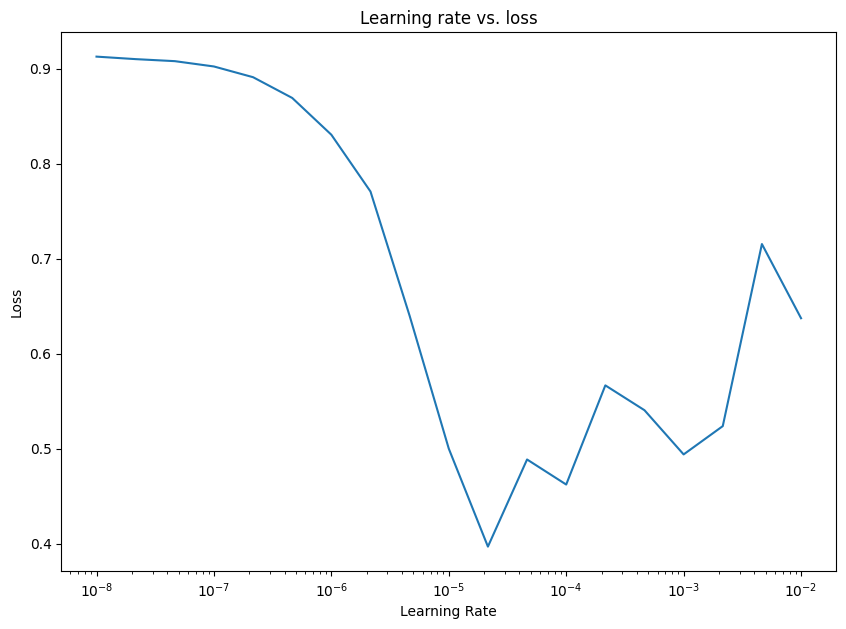

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-8 * (10 ** (np.arange(num_epochs)/3))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss")

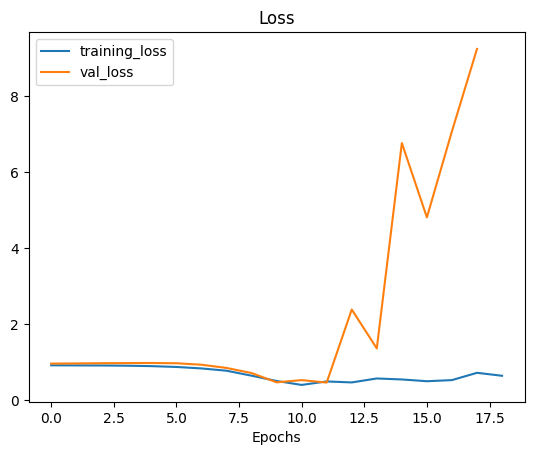

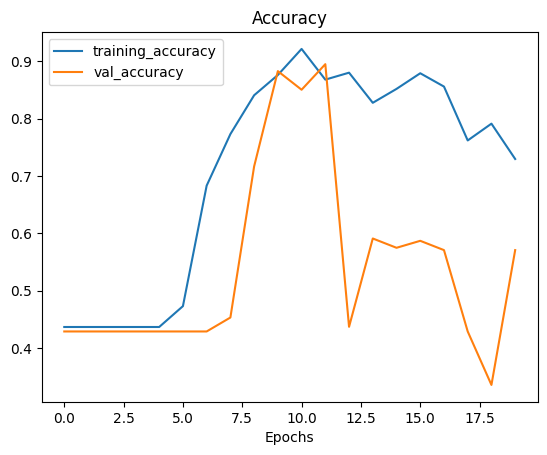

In [ ]:
plot_loss_curves(history)

### Fitting the the ideal learning rate

In [8]:
NORMALIZATION = "minmax" # Determine the intensity normalization to use: "minmax", "zscore"
DATASET = "smci_pmci" # Determine the dataset to use: "smci_pmci" or "nc_ad"

In [9]:
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET

BATCH_SIZE = 16 # Set batch size for training
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET nifti images

# Create train dataset
train_data = create_dataset(
    data_dir=DATA_DIR,
    split='train',
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed
)

# Create test dataset
test_data = create_dataset(
        data_dir=DATA_DIR,
        split='test',
        batch_size=BATCH_SIZE,
        volume_shape=VOLUME_SHAPE,
        is_training=False,
        seed=None
    )

# Check if the datasets were successfully created
if train_data is None:
    print("ERROR: Train dataset could not be created.")
    exit()
if test_data is None:
    print("ERROR: Test dataset could not be created.")
    exit()

Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/train...
Found 575 files for class 'smci'
Found 312 files for class 'pmci'
Dataset created for split 'train'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Found classes: ['smci', 'pmci']
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/minmax/smci_pmci/test...
Found 143 files for class 'smci'
Found 80 files for class 'pmci'
Dataset created for split 'test'. Spec: (TensorSpec(shape=(None, 91, 109, 91, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [10]:
from Resnet3D_model import Resnet3DBuilder

# Create the ResNet34 model
model34 = Resnet3DBuilder.build_resnet_34((91, 109, 91, 1), 1, reg_factor=0)

# Compile the model
model34.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
              metrics=["accuracy"])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)
# callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/5))

history34 = model34.fit(train_data, epochs=50, validation_data=test_data, verbose=1, callbacks=[early_stopping])

here CHANNELS last
Epoch 1/50


I0000 00:00:1744111995.584850   70418 service.cc:145] XLA service 0x7fabb4001e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744111995.584890   70418 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-04-08 12:33:16.508033: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-08 12:33:18.630815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-04-08 12:33:28.547712: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1744112019.156785   70418 asm_compiler.cc:369] ptxas warning : Registers ar

55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8052 - loss: 0.7299

2025-04-08 12:33:54.664286: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
I0000 00:00:1744112045.593466   70419 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_224__5', 12 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4__8', 2424 bytes spill stores, 2376 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm70_shflsync_down', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_9__7', 2148 bytes spill stores, 1984 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__

56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 602ms/step - accuracy: 0.7997 - loss: 0.7331 - val_accuracy: 0.6413 - val_loss: 0.8428
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.7929 - loss: 0.6885 - val_accuracy: 0.6413 - val_loss: 0.8347
Epoch 3/50


2025-04-08 12:34:22.336379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.8411 - loss: 0.6547 - val_accuracy: 0.6413 - val_loss: 0.8344
Epoch 4/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 14s 263ms/step - accuracy: 0.8750 - loss: 0.6473

2025-04-08 12:34:32.403551: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8730 - loss: 0.6148

2025-04-08 12:34:40.763694: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.8726 - loss: 0.6147 - val_accuracy: 0.6413 - val_loss: 0.8270
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8737 - loss: 0.5777

2025-04-08 12:34:50.538348: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.8740 - loss: 0.5770 - val_accuracy: 0.6413 - val_loss: 0.8073
Epoch 6/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.8125 - loss: 0.6383

2025-04-08 12:34:51.620181: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8756 - loss: 0.5391

2025-04-08 12:34:59.794087: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.8761 - loss: 0.5378 - val_accuracy: 0.6457 - val_loss: 0.7748
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8910 - loss: 0.4858

2025-04-08 12:35:09.371748: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8917 - loss: 0.4842 - val_accuracy: 0.6592 - val_loss: 0.7334
Epoch 8/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.8750 - loss: 0.6231

2025-04-08 12:35:10.525869: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8947 - loss: 0.4565

2025-04-08 12:35:18.501651: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.8955 - loss: 0.4548 - val_accuracy: 0.7937 - val_loss: 0.6715
Epoch 9/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.8125 - loss: 0.5926

2025-04-08 12:35:19.689895: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9232 - loss: 0.3986

2025-04-08 12:35:27.865410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9239 - loss: 0.3969 - val_accuracy: 0.7892 - val_loss: 0.6283
Epoch 10/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 14s 269ms/step - accuracy: 0.7500 - loss: 0.6184

2025-04-08 12:35:29.266412: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9492 - loss: 0.3654

2025-04-08 12:35:37.690273: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9497 - loss: 0.3639 - val_accuracy: 0.8296 - val_loss: 0.5821
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9496 - loss: 0.3541 - val_accuracy: 0.8341 - val_loss: 0.6217
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9736 - loss: 0.3354

2025-04-08 12:35:56.831581: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9738 - loss: 0.3340 - val_accuracy: 0.8430 - val_loss: 0.5963
Epoch 13/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9375 - loss: 0.4851

2025-04-08 12:35:57.931880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9750 - loss: 0.3266

2025-04-08 12:36:06.315016: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9752 - loss: 0.3252 - val_accuracy: 0.8386 - val_loss: 0.6280
Epoch 14/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 1.0000 - loss: 0.4672

2025-04-08 12:36:07.484102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9906 - loss: 0.2997

2025-04-08 12:36:15.850006: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9907 - loss: 0.2985 - val_accuracy: 0.8251 - val_loss: 0.7049
Epoch 15/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9906 - loss: 0.3062

2025-04-08 12:36:26.680262: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.9906 - loss: 0.3049 - val_accuracy: 0.8341 - val_loss: 0.6833
Epoch 16/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 1.0000 - loss: 0.4530

2025-04-08 12:36:27.862984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9934 - loss: 0.2829

2025-04-08 12:36:36.241070: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.9934 - loss: 0.2819 - val_accuracy: 0.8251 - val_loss: 0.7187
Epoch 17/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9795 - loss: 0.2905

2025-04-08 12:36:46.090720: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9797 - loss: 0.2895 - val_accuracy: 0.8386 - val_loss: 0.6996
Epoch 18/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - accuracy: 1.0000 - loss: 0.4223

2025-04-08 12:36:47.270001: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9943 - loss: 0.2836

2025-04-08 12:36:55.304372: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9944 - loss: 0.2825 - val_accuracy: 0.8386 - val_loss: 0.7353
Epoch 19/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9862 - loss: 0.2739

2025-04-08 12:37:04.296076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9864 - loss: 0.2730 - val_accuracy: 0.8296 - val_loss: 0.6828
Epoch 20/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 1.0000 - loss: 0.3825

2025-04-08 12:37:05.371487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9960 - loss: 0.2674

2025-04-08 12:37:13.554616: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9960 - loss: 0.2665 - val_accuracy: 0.8072 - val_loss: 0.9083
Epoch 21/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 14s 270ms/step - accuracy: 1.0000 - loss: 0.4050

2025-04-08 12:37:14.796859: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9972 - loss: 0.2752

2025-04-08 12:37:22.914041: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9972 - loss: 0.2742 - val_accuracy: 0.8206 - val_loss: 0.8020
Epoch 22/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9939 - loss: 0.2689

2025-04-08 12:37:32.388656: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9940 - loss: 0.2680 - val_accuracy: 0.8161 - val_loss: 0.8014
Epoch 23/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9375 - loss: 0.5029

2025-04-08 12:37:33.491217: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9948 - loss: 0.2719

2025-04-08 12:37:41.561755: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9949 - loss: 0.2709 - val_accuracy: 0.8386 - val_loss: 0.7606


In [11]:
model34.evaluate(test_data)

 2/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.2126 

2025-04-08 12:37:52.947025: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9386 - loss: 0.3998


[0.7605976462364197, 0.8385650515556335]

In [12]:
y_pred = model34.predict(test_data)

2025-04-08 12:37:55.540409: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109120 bytes after encountering the first element of size 67109120 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step


In [13]:
y_true = []
for batch in test_data.as_numpy_iterator():
    # Assuming your dataset yields (features, labels) tuples
    # Access the labels (usually the second element, index 1)
    labels_in_batch = batch[1]
    y_true.append(labels_in_batch)
y_true = np.concatenate(y_true)
y_true

2025-04-08 12:38:01.819528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=flo

In [14]:
class0, class1 = DATASET.split("_")
target_names = [class0, class1]
print(classification_report(y_true, y_pred.round(), target_names=target_names))

              precision    recall  f1-score   support

        smci       0.82      0.97      0.88       143
        pmci       0.91      0.61      0.73        80

    accuracy                           0.84       223
   macro avg       0.86      0.79      0.81       223
weighted avg       0.85      0.84      0.83       223



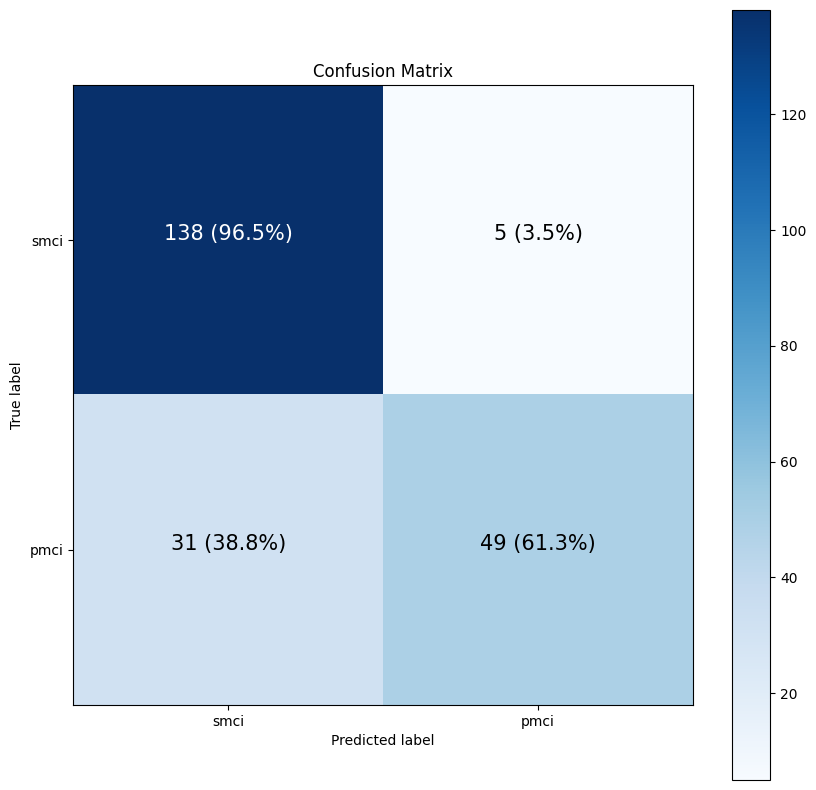

In [15]:
make_confusion_matrix(y_true=y_true,
                      y_pred=y_pred.round(),
                      classes=target_names,
                      figsize=(10, 10),
                      text_size=15)

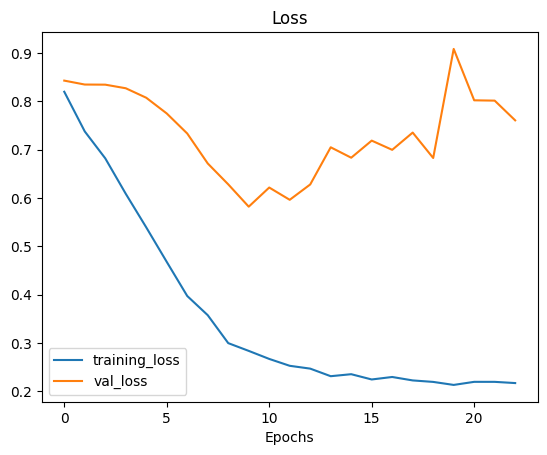

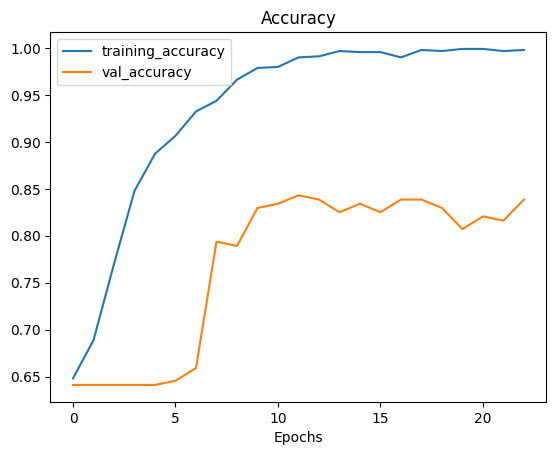

In [16]:
plot_loss_curves(history34)

### Save the model

In [17]:
model34.save("/home/diogommiranda/tese/models/Resnet34/smci_pmci/minmax/Resnet34_batches16.keras")